# evaluate the enformer type models

In [1]:
#first let's load in the test data
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset
dataset = enformer_dataset.EnformerDataset('test', 160_000, rc_aug = False, load_into_memory=True)

In [2]:
#now we can load in the model and evaluate the data
print(dataset.labels.shape)

(1937, 896, 5313)


In [3]:
for i in dataset:
    2
print(i[0].shape)
print(i[1].shape)
#like half a second to load it all if it's in memory...

torch.Size([160000])
torch.Size([896, 4675])


In [4]:
dataset.labels.nbytes/1e9 #actually 37 GB!

36.883951104

In [5]:
#now we can load in the model and evaluate the data
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

In [6]:
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)

1 {'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 8, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 160002, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False} {'d_output': 1}


In [7]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-06/14-21-57-902384/checkpoints/01-val_loss=0.79042.ckpt'
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(model_cfg['d_model'], l_output=0, mode='pool', d_output=4675)
state_dict = torch.load(ckpt_path, map_location='cpu')

In [8]:
decoder

EnformerDecoder(
  (output_transform): Linear(in_features=256, out_features=4675, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

odict_keys(['decoder.0.output_transform.weight', 'decoder.0.output_transform.bias', 'backbone.embeddings.word_embeddings.weight', 'backbone.layers.0.mixer.filter_fn.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.0.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.0.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.1.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.2.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.2.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.3.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.4.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.4.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.5.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.6.weight', 'backbone.layers.0.mixer.filter_fn.modulation.deltas', 'backbone.layers.0.mixer.filter_fn.pos_emb.t', 'backbone.layers.0.mixer.filter_fn.pos_emb.z', 'backbone.layers.0.mixer.in_proj.bias', 'backbone.layers.0.mixer.in_pro

In [10]:

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
# decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
# decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')

In [11]:
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [14]:
#now we can evaluate the entire test set!
from tqdm import tqdm
#make output the same shape as labels
output = torch.zeros(dataset.labels.shape)
output = output[:,:,:4675]
with torch.no_grad():
    idx = 0
    for i in tqdm(dataset):
        x, y = i
        x = x.to(device).unsqueeze(0)
        y = y.to(device).unsqueeze(0)
        out,_ = backbone(x)
        out = decoder(out)
        #and assign it
        output[idx] = out.cpu().detach().squeeze(0)
        idx += 1
        # print(out.shape)
        # print(y.shape)
        # break

: 

In [12]:
#let's instead just run it here
#just look at a single example!
with torch.no_grad():
    x, y = dataset[0]
    x = x.to(device).unsqueeze(0)
    y = y.to(device).unsqueeze(0)
    out,_ = backbone(x)
    out = decoder(out)
    print(out.shape)
    print(y.shape)

torch.Size([1, 896, 4675])
torch.Size([1, 896, 4675])


In [13]:
#now let's look at this example!
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#first of all turn to numpy
out = out.cpu().detach().squeeze(0).numpy()
y = y.cpu().detach().squeeze(0).numpy()

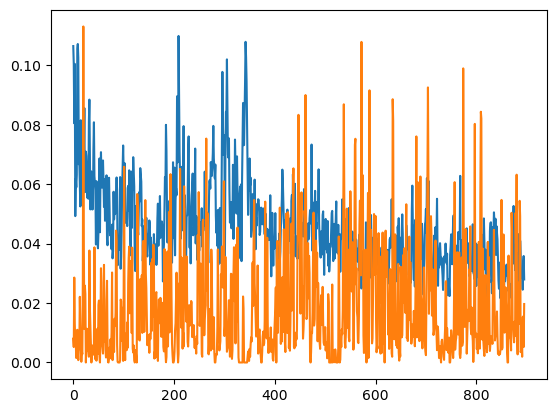

In [16]:
#now let's plot one of the tracks, the k562 track
#index 121 seems good!
plt.plot(np.exp(out[:,121]))
plt.plot(y[:,121])

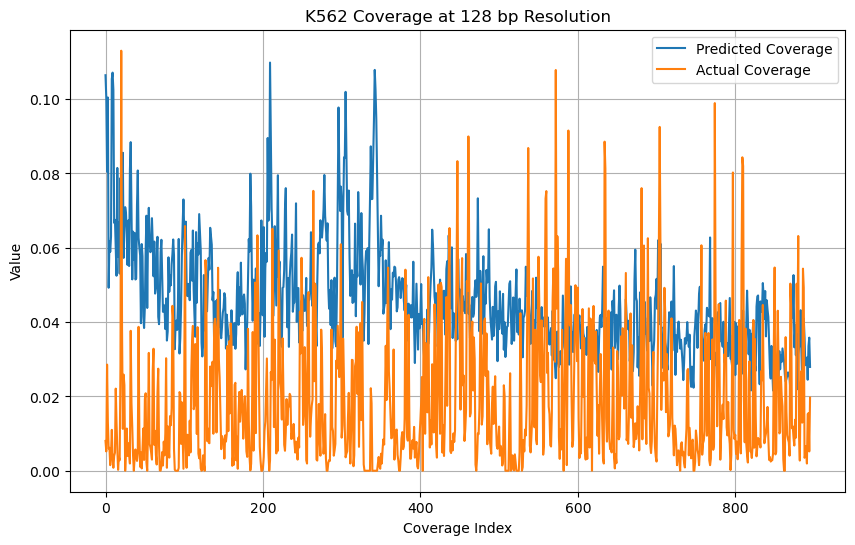

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')

# Adding title and labels
plt.title('K562 Coverage at 128 bp Resolution')
plt.xlabel('Coverage Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

torch.Size([1, 896, 4675])
torch.Size([1, 896, 4675])


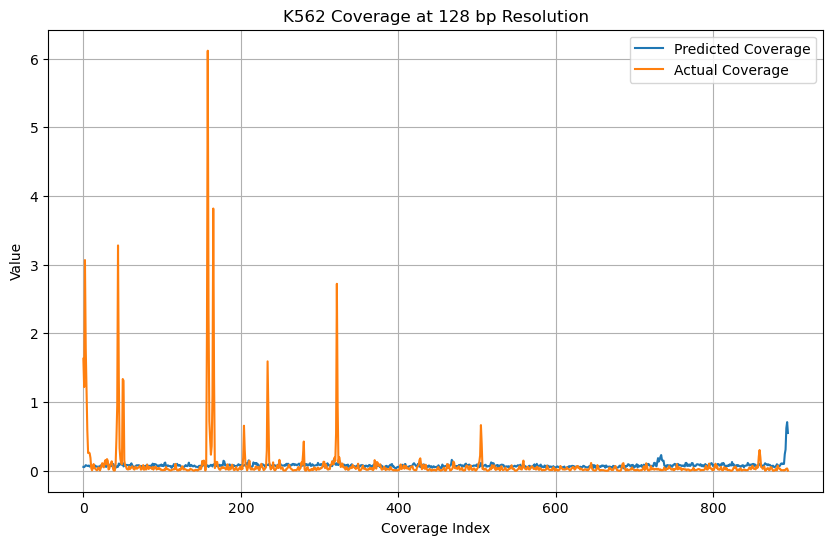

In [19]:
#the next data point
with torch.no_grad():
    x, y = dataset[1]
    x = x.to(device).unsqueeze(0)
    y = y.to(device).unsqueeze(0)
    out,_ = backbone(x)
    out = decoder(out)
    print(out.shape)
    print(y.shape)
#and plot
out = out.cpu().detach().squeeze(0).numpy()
y = y.cpu().detach().squeeze(0).numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')

# Adding title and labels
plt.title('K562 Coverage at 128 bp Resolution')
plt.xlabel('Coverage Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# testing if we can evaluate the k562 one

In [14]:
#first let's load in the test data
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset

#these are the only things we modify
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-08/18-02-08-037661/checkpoints/last.ckpt'
convolutions = True
dataset = enformer_dataset.EnformerDataset('test', 160_000, rc_aug = False, load_into_memory=False, cell_type='K562')



#now we can load in the model and evaluate the data
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)
d_output = dataset.d_output
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(model_cfg['d_model'], l_output=0, mode='pool', d_output=d_output, convolutions=convolutions)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key or "output_transform" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
# decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
# decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
# decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
# decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

1 {'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 8, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 160002, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False} {'d_output': 1}


In [15]:
decoder

EnformerDecoder(
  (conv1): Conv1d(256, 256, kernel_size=(12,), stride=(1,))
  (conv2): Conv1d(256, 256, kernel_size=(6,), stride=(1,))
  (conv3): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (output_transform): Linear(in_features=256, out_features=387, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
)

In [19]:
#check how much cuda memory is used currently
torch.cuda.memory_allocated()//1e9 #allocated 24 gb, which is the size of the model

24.0

In [20]:
ex1 = dataset[0]
device = 'cpu'
backbone = backbone.to(device)
decoder = decoder.to(device)
#now evaluate
out1,_ = backbone(ex1[0].unsqueeze(0).to(device))
out2 = decoder(out1)
print(out2.shape)
#16 secodns to load and evaluate even on the cpu is not bad!

torch.Size([1, 896, 387])


In [21]:
#now let's plot it
import matplotlib.pyplot as plt
import numpy as np

out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex1[1].numpy()

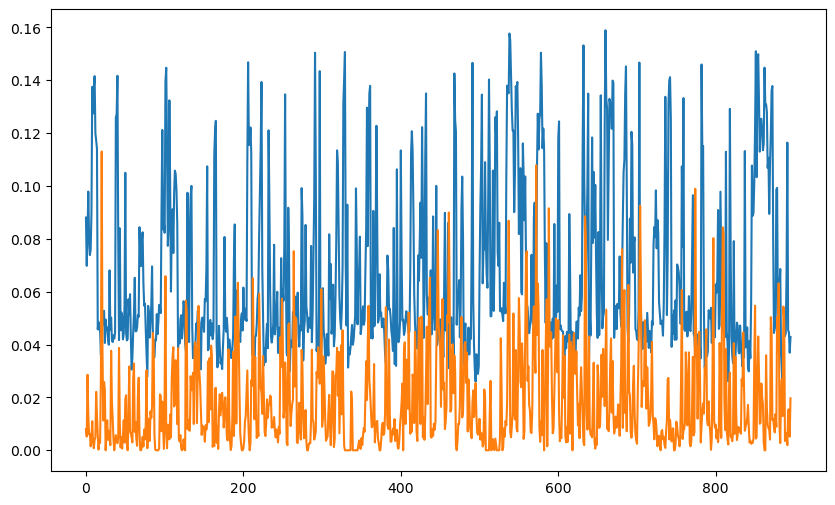

In [22]:
#and now plot
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 0]), label='Predicted Coverage')
plt.plot(y[:, 0], label='Actual Coverage')

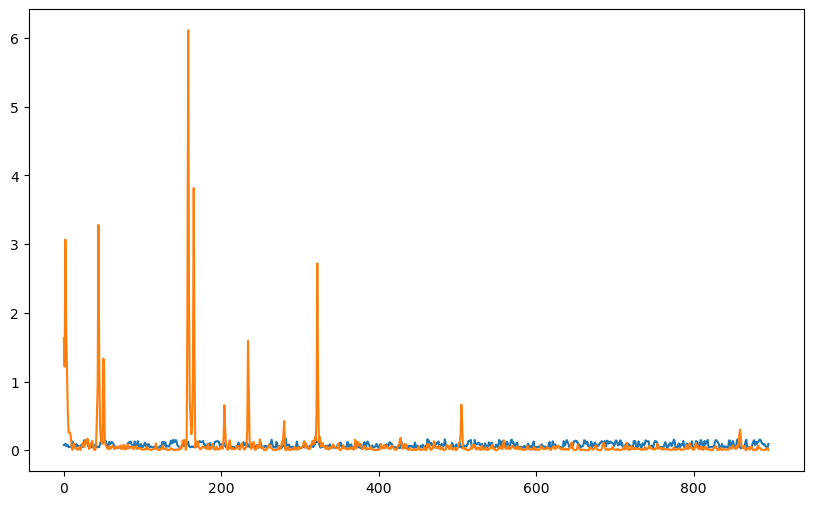

In [23]:
#let's look at the next exmaple
ex2 = dataset[1]
out1,_ = backbone(ex2[0].unsqueeze(0).to(device))
out2 = decoder(out1)
out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex2[1].numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 0]), label='Predicted Coverage')
plt.plot(y[:, 0], label='Actual Coverage')

#wait this is really bad???

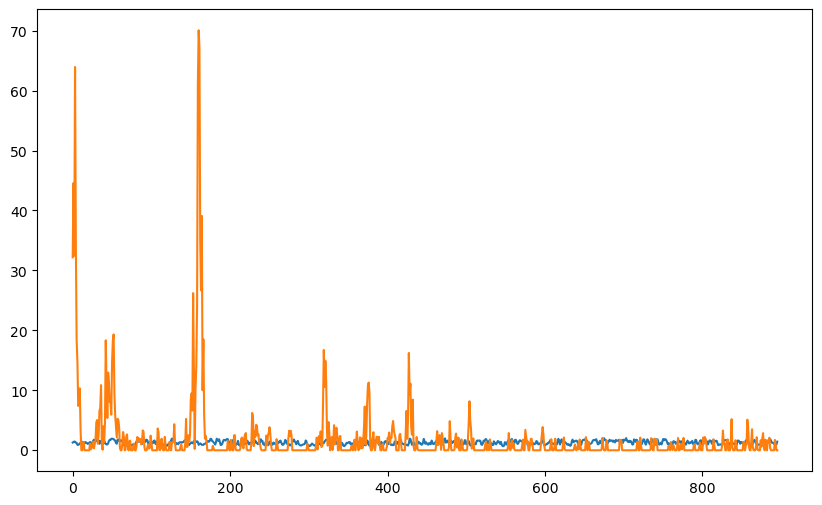

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 7]), label='Predicted Coverage')
plt.plot(y[:, 7], label='Actual Coverage')
#theyr'e just all like this...

# let's check the linear model

In [3]:
#first let's load in the test data
#also limit cuda visible deices to just be gpu 1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset

#these are the only things we modify
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-08/17-59-32-315467/checkpoints/06-val_loss=0.66658.ckpt'
convolutions = False
dataset = enformer_dataset.EnformerDataset('test', 160_000, rc_aug = False, load_into_memory=False)



#now we can load in the model and evaluate the data
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)
d_output = dataset.d_output
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(model_cfg['d_model'], l_output=0, mode='pool', d_output=d_output, convolutions=convolutions)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key or "output_transform" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
# decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
# decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
# decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
# decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
device = 'cpu'
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

1 {'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 8, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 160002, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False} {'d_output': 1}


In [4]:
#now we can evaluate an example
device = 'cpu'
backbone = backbone.to(device)
decoder = decoder.to(device)
ex2 = dataset[1]
out1,_ = backbone(ex2[0].unsqueeze(0).to(device))
out2 = decoder(out1)
out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex2[1].numpy()

#so has to predict a lot more, but maybe able to learn a lot more like enformer?

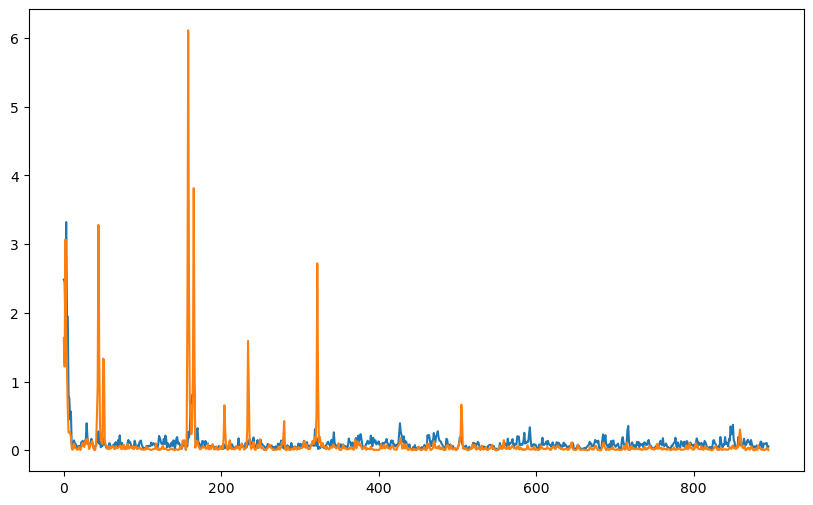

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')

#yeah, seems to be a lot better... I think maybe cuz of convol;utions? or is it just the model? idk

Text(0.5, 1.0, 'Hyena linear model predictions on K562 data')

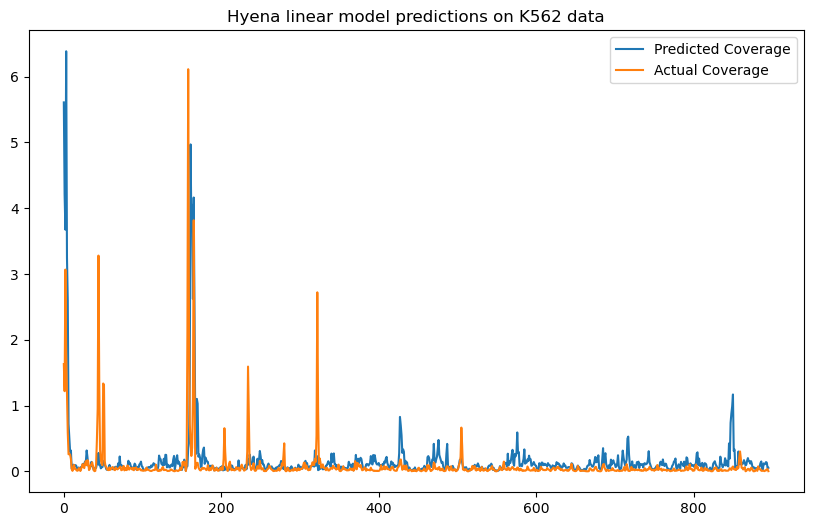

In [7]:
#this is a later epoch
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
plt.legend()
# plt.grid(True)
plt.title('Hyena linear model predictions on K562 data')

In [8]:
#correlate them
np.corrcoef(np.exp(out2[:, 121]), y[:, 121])

array([[1.        , 0.45224191],
       [0.45224191, 1.        ]])

In [4]:
#now do for k562
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-08/17-55-56-725684/checkpoints/03-val_loss=0.78926.ckpt'
convolutions = True
# dataset = enformer_dataset.EnformerDataset('test', 160_000, rc_aug = False, load_into_memory=False)

#now we can load in the model and evaluate the data
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)
d_output = dataset.d_output
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(model_cfg['d_model'], l_output=0, mode='pool', d_output=d_output, convolutions=convolutions)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key or "output_transform" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
# decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
# decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
# decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
# decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

1 {'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 8, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 160002, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False} {'d_output': 1}


Text(0.5, 1.0, 'convolutions model')

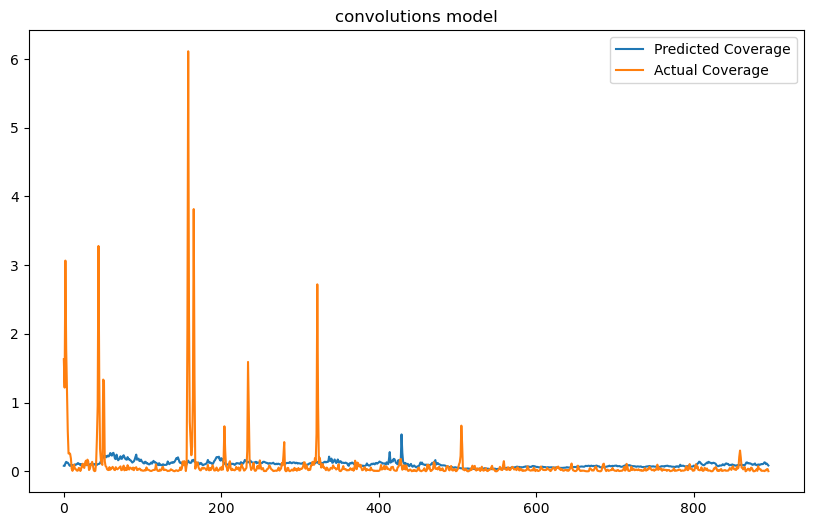

In [5]:
#now we can evaluate an example
device = 'cpu'
backbone = backbone.to(device)
decoder = decoder.to(device)
ex2 = dataset[1]
out1,_ = backbone(ex2[0].unsqueeze(0).to(device))
out2 = decoder(out1)
out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex2[1].numpy()

#so has to predict a lot more, but maybe able to learn a lot more like enformer?
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
#and add legend
plt.legend()
plt.title('convolutions model')

#the convolutions model doesn't seem nearly as good, likely my architecture

# let's try mamba too

In [2]:
import torch
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/checkpoints/00-val_loss=0.89760.ckpt'
#remember this mamba model has not been pretrained!

import yaml
cfg = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/model_config.json'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
# train_cfg = cfg['train']  # grab section `train` section of config
# model_cfg = cfg['model_config']  # grab the `model` section of config
print(cfg)
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

{'config': {'_target_': 'caduceus.configuration_caduceus.CaduceusConfig', 'd_model': 256, 'n_layer': 16, 'vocab_size': 12, 'ssm_cfg': {'d_state': 16, 'd_conv': 4, 'expand': 2, 'dt_rank': 'auto', 'dt_min': 0.001, 'dt_max': 0.1, 'dt_init': 'random', 'dt_scale': 1.0, 'dt_init_floor': 0.0001, 'conv_bias': True, 'bias': False, 'use_fast_path': True}, 'rms_norm': True, 'fused_add_norm': True, 'residual_in_fp32': False, 'pad_vocab_size_multiple': 8, 'norm_epsilon': '1e-05', 'initializer_cfg': {'initializer_range': 0.02, 'rescale_prenorm_residual': True, 'n_residuals_per_layer': 1}, 'bidirectional': True, 'bidirectional_strategy': 'add', 'bidirectional_weight_tie': True, 'rcps': True, 'complement_map': None}}


odict_keys(['decoder.0.output_transform.weight', 'decoder.0.output_transform.bias', 'caduceus.backbone.embeddings.word_embeddings.complement_map', 'caduceus.backbone.embeddings.word_embeddings.embedding.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.A_log', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.D', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.conv1d.bias', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.conv1d.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.dt_proj.bias', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.dt_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.in_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.out_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.x_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_rev.A_log', 'caduceus.backbone.layers.0.mixer.submodule.mamba_rev.D', 'caduceus.backbone.layers.0.mixer.submodule.mamba_rev.con

In [3]:
#so we need to find the right model to load then!
#location of the backbone is here
#/data/leslie/sarthak/caduceus/src/models/sequence/dna_embedding.py

import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus


In [8]:
cfg['config']

AttributeError: 'dict' object has no attribute 'd_model'

In [9]:
#need to create the config

from typing import Optional, Union

from transformers import PretrainedConfig


class CaduceusConfig(PretrainedConfig):
    """Config that extends the original MambaConfig with params relevant to bi-directionality and RC equivariance."""
    model_type = "caduceus"

    def __init__(
            self,
            # From original MambaConfig
            d_model: int = 2560,
            n_layer: int = 64,
            vocab_size: int = 50277,
            ssm_cfg: Optional[dict] = None,
            rms_norm: bool = True,
            residual_in_fp32: bool = True,
            fused_add_norm: bool = True,
            pad_vocab_size_multiple: int = 8,

            # Not in original MambaConfig, but default arg in create_block in mamba_ssm repo; used in layer norm
            norm_epsilon: float = 1e-5,

            # Used in init_weights
            initializer_cfg: Optional[dict] = None,

            # Caduceus-specific params
            bidirectional: bool = True,
            bidirectional_strategy: Union[str, None] = "add",
            bidirectional_weight_tie: bool = True,
            rcps: bool = False,
            complement_map: Optional[dict] = None,  # used for RCPSEmbedding / RCPSLMHead
            **kwargs,
    ):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.n_layer = n_layer
        self.vocab_size = vocab_size
        self.ssm_cfg = ssm_cfg
        self.rms_norm = rms_norm
        self.residual_in_fp32 = residual_in_fp32
        self.fused_add_norm = fused_add_norm
        self.pad_vocab_size_multiple = pad_vocab_size_multiple
        self.norm_epsilon = norm_epsilon
        self.initializer_cfg = initializer_cfg
        self.bidirectional = bidirectional
        self.bidirectional_strategy = bidirectional_strategy
        self.bidirectional_weight_tie = bidirectional_weight_tie
        self.rcps = rcps
        self.complement_map = complement_map


#now define the config
config = CaduceusConfig(**cfg['config'])

In [10]:
config

CaduceusConfig {
  "_target_": "caduceus.configuration_caduceus.CaduceusConfig",
  "bidirectional": true,
  "bidirectional_strategy": "add",
  "bidirectional_weight_tie": true,
  "complement_map": null,
  "d_model": 256,
  "fused_add_norm": true,
  "initializer_cfg": {
    "initializer_range": 0.02,
    "n_residuals_per_layer": 1,
    "rescale_prenorm_residual": true
  },
  "model_type": "caduceus",
  "n_layer": 16,
  "norm_epsilon": "1e-05",
  "pad_vocab_size_multiple": 8,
  "rcps": true,
  "residual_in_fp32": false,
  "rms_norm": true,
  "ssm_cfg": {
    "bias": false,
    "conv_bias": true,
    "d_conv": 4,
    "d_state": 16,
    "dt_init": "random",
    "dt_init_floor": 0.0001,
    "dt_max": 0.1,
    "dt_min": 0.001,
    "dt_rank": "auto",
    "dt_scale": 1.0,
    "expand": 2,
    "use_fast_path": true
  },
  "transformers_version": "4.38.1",
  "vocab_size": 12
}

In [11]:
#now let's see how we can use the config to run it?
backbone = DNAEmbeddingModelCaduceus(config)

AssertionError: Complement map must be provided for RCPS.

In [14]:
#let's combine the configs to get a complement map
cfgpath2 = '/data/leslie/sarthak/caduceus/caduceus-ps_seqlen-131k_d_model-256_n_layer-16/config.json'
cfg2 = yaml.load(open(cfgpath2, 'r'), Loader=yaml.FullLoader)
config2 = CaduceusConfig(**cfg2)
config2

CaduceusConfig {
  "architectures": [
    "CaduceusForMaskedLM"
  ],
  "auto_map": {
    "AutoConfig": "configuration_caduceus.CaduceusConfig",
    "AutoModel": "modeling_caduceus.Caduceus",
    "AutoModelForMaskedLM": "modeling_caduceus.CaduceusForMaskedLM",
    "AutoModelForSequenceClassification": "modeling_caduceus.CaduceusForSequenceClassification"
  },
  "bidirectional": true,
  "bidirectional_strategy": "add",
  "bidirectional_weight_tie": true,
  "complement_map": {
    "0": 0,
    "1": 1,
    "10": 7,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 10,
    "8": 9,
    "9": 8
  },
  "d_model": 256,
  "fused_add_norm": true,
  "initializer_cfg": {
    "initializer_range": 0.02,
    "n_residuals_per_layer": 1,
    "rescale_prenorm_residual": true
  },
  "model_type": "caduceus",
  "n_layer": 16,
  "norm_epsilon": "1e-05",
  "pad_vocab_size_multiple": 8,
  "rcps": true,
  "residual_in_fp32":

In [15]:
config.complement_map = config2.complement_map

In [16]:
backbone = DNAEmbeddingModelCaduceus(config)

In [17]:
backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(16, 256)
        )
      )
      (layers): ModuleList(
        (0-15): 16 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
                (act): SiLU()
                (x_proj): Linear(in_features=512, out_features=48, bias=False)
                (dt_proj): Linear(in_features=16, out_features=512, bias=True)
                (out_proj): Linear(in_features=512, out_features=256, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
               

In [3]:
sys.path

['/lila/data/leslie/sarthak',
 '/data/leslie/sarthak/environments/mambadna/lib/python311.zip',
 '/data/leslie/sarthak/environments/mambadna/lib/python3.11',
 '/data/leslie/sarthak/environments/mambadna/lib/python3.11/lib-dynload',
 '',
 '/data/leslie/sarthak/environments/mambadna/lib/python3.11/site-packages',
 '/data/leslie/sarthak/caduceus/']

In [2]:
#now combine it all in 1

import sys
sys.path.append('/data/leslie/sarthak/caduceus/')

import torch
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/checkpoints/00-val_loss=0.89760.ckpt'
#remember this mamba model has not been pretrained!

from caduceus.configuration_caduceus import CaduceusConfig
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus


# complement_map = {
#     "0": 0,
#     "1": 1,
#     "2": 2,
#     "3": 3,
#     "4": 4,
#     "5": 5,
#     "6": 6,
#     "7": 10,
#     "8": 9,
#     "9": 8,
#     "10": 7,
#     "11": 11,
#     "12": 12,
#     "13": 13,
#     "14": 14,
#     "15": 15
#   }

import yaml
cfg = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/model_config.json'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
# train_cfg = cfg['train']  # grab section `train` section of config
# model_cfg = cfg['model_config']  # grab the `model` section of config
# print(cfg)
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# model_state_dict.keys()

config = CaduceusConfig(**cfg['config'])
# config.complement_map = complement_map
#added complement map to automatically be that default one!
backbone = DNAEmbeddingModelCaduceus(config)



In [3]:
backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(16, 256)
        )
      )
      (layers): ModuleList(
        (0-15): 16 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
                (act): SiLU()
                (x_proj): Linear(in_features=512, out_features=48, bias=False)
                (dt_proj): Linear(in_features=16, out_features=512, bias=True)
                (out_proj): Linear(in_features=512, out_features=256, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
               

In [8]:
#and the decoder

full_cfg_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/config.json'
cfg = yaml.load(open(full_cfg_path, 'r'), Loader=yaml.FullLoader)
print(cfg['model']['config'])
cfg = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/model_config.json'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
print(cfg['config'])

#literally identical, so just load in the full config instead of th epartial one, that way can get decoder information too!!

{'_target_': 'caduceus.configuration_caduceus.CaduceusConfig', 'd_model': 256, 'n_layer': 16, 'vocab_size': 12, 'ssm_cfg': {'d_state': 16, 'd_conv': 4, 'expand': 2, 'dt_rank': 'auto', 'dt_min': 0.001, 'dt_max': 0.1, 'dt_init': 'random', 'dt_scale': 1.0, 'dt_init_floor': 0.0001, 'conv_bias': True, 'bias': False, 'use_fast_path': True}, 'rms_norm': True, 'fused_add_norm': True, 'residual_in_fp32': False, 'pad_vocab_size_multiple': 8, 'norm_epsilon': '1e-05', 'initializer_cfg': {'initializer_range': 0.02, 'rescale_prenorm_residual': True, 'n_residuals_per_layer': 1}, 'bidirectional': True, 'bidirectional_strategy': 'add', 'bidirectional_weight_tie': True, 'rcps': True, 'complement_map': None}
{'_target_': 'caduceus.configuration_caduceus.CaduceusConfig', 'd_model': 256, 'n_layer': 16, 'vocab_size': 12, 'ssm_cfg': {'d_state': 16, 'd_conv': 4, 'expand': 2, 'dt_rank': 'auto', 'dt_min': 0.001, 'dt_max': 0.1, 'dt_init': 'random', 'dt_scale': 1.0, 'dt_init_floor': 0.0001, 'conv_bias': True, 'bi

In [10]:
full_cfg_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/config.json'
cfg = yaml.load(open(full_cfg_path, 'r'), Loader=yaml.FullLoader)

cfg['decoder']

{'_name_': 'enformer',
 'mode': 'pool',
 'd_model': 256,
 'd_output': 4675,
 'conjoin_train': True,
 'conjoin_test': False}

In [15]:
from src.tasks.decoders import EnformerDecoder
#pop name from cfg['decoder']
full_cfg_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/config.json'
cfg = yaml.load(open(full_cfg_path, 'r'), Loader=yaml.FullLoader)
name = cfg['decoder'].pop('_name_')
decoder = EnformerDecoder(**cfg['decoder'])
decoder

EnformerDecoder(
  (output_transform): Linear(in_features=256, out_features=4675, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
)

In [14]:
#all of this seems good, let's combine it together again

import sys
sys.path.append('/data/leslie/sarthak/caduceus/')

import torch
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/checkpoints/00-val_loss=0.89760.ckpt'
#remember this mamba model has not been pretrained!

from caduceus.configuration_caduceus import CaduceusConfig
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.dataloaders.datasets.enformer_dataset import EnformerDataset

dataset = EnformerDataset('test', 131_072, rc_aug = False, load_into_memory=False, cell_type='K562')

import yaml
cfg = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/config.json'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
# train_cfg = cfg['train']  # grab section `train` section of config
# model_cfg = cfg['model_config']  # grab the `model` section of config
# print(cfg)
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# model_state_dict.keys()

config = CaduceusConfig(**cfg['model']['config'])
# config.complement_map = complement_map
#added complement map to automatically be that default one!
backbone = DNAEmbeddingModelCaduceus(config)
cfg['decoder'].pop('_name_')
cfg['decoder']['d_output'] = dataset.d_output
decoder = EnformerDecoder(**cfg['decoder'])

In [15]:
#now we load in the weights
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key or "output_transform" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
print(decoder_state_dict.keys())

dict_keys(['output_transform.weight', 'output_transform.bias'])


In [16]:
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
device = 'cpu'
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [18]:
ex2[0].unsqueeze(0).shape

torch.Size([1, 131072])

In [19]:
ex2[0].dtype

torch.int64

In [17]:
#now let's get the same ex2
ex2 = dataset[1]
out1,_ = backbone(ex2[0].unsqueeze(0).to(device))
out2 = decoder(out1)
out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex2[1].numpy()

TypeError: Unsupported type <class 'str'> for 1e-05

In [ ]:
#and plot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
plt.legend()

In [37]:
#let's manually go through the backbone
x = ex2[0].unsqueeze(0).to(device)
embed = backbone.caduceus.backbone.embeddings.word_embeddings.embedding(x)
print(embed.shape)

torch.Size([1, 131072, 256])


In [38]:
embed2 = backbone.caduceus.backbone.embeddings(x)
print(embed2.shape)

torch.Size([1, 131072, 512])


In [39]:
#this seems to be the RC that is embed
print(embed2) #only along the rows at the end are they different cuz one is longer
print(embed)
#seems similar enough and so far nothing seems wrong...

tensor([[[-0.6449, -0.4056, -1.0955,  ..., -0.7847, -1.0886,  0.1294],
         [ 0.1294, -1.0886, -0.7847,  ..., -1.0955, -0.4056, -0.6449],
         [ 0.1294, -1.0886, -0.7847,  ..., -1.0955, -0.4056, -0.6449],
         ...,
         [-0.6449, -0.4056, -1.0955,  ..., -0.7847, -1.0886,  0.1294],
         [ 0.1294, -1.0886, -0.7847,  ..., -1.0955, -0.4056, -0.6449],
         [-0.6449, -0.4056, -1.0955,  ..., -0.7847, -1.0886,  0.1294]]],
       grad_fn=<CatBackward0>)
tensor([[[-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033],
         [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
         [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
         ...,
         [-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033],
         [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
         [-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033]]],
       grad_fn=<EmbeddingBackward0>)


In [45]:
print(embed[0,:7,:10])
print(embed2[0,:7,:10])

tensor([[-0.6449, -0.4056, -1.0955,  0.3773, -1.4168,  0.9345,  0.5010,  2.4539,
          0.0542, -1.2399],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0.1991],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0.1991],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0.1991],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0.1991],
        [ 0.4272, -0.4948, -0.7136,  0.8435,  0.6800, -0.2795, -1.2354,  0.7560,
          0.9976,  0.3461],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0.1991]], grad_fn=<SliceBackward0>)
tensor([[-0.6449, -0.4056, -1.0955,  0.3773, -1.4168,  0.9345,  0.5010,  2.4539,
          0.0542, -1.2399],
        [ 0.1294, -1.0886, -0.7847, -0.2070,  0.2804,  1.3919, -1.5868, -3.2415,
         -0.0797, -0

In [52]:
#it's the RCeq embedding, so basically should be identical in both directions, let's test it
torch.allclose(embed[0,:,:256], embed2[0,:,:256])

True

In [56]:
embed2[0,:,256:].shape

torch.Size([131072, 256])

In [57]:
torch.allclose(embed[0,:,:256], torch.flip(embed2[0,:,256:], dims=[1]))

False

In [58]:
#print them
print(embed[0,:,:256])
print(embed2[0,:,256:])
#this is quite different indeed! Doesn't end the same at all anymore!! That's fine tho, we just have a larger embedding

tensor([[-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033],
        [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
        [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
        ...,
        [-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033],
        [ 0.1294, -1.0886, -0.7847,  ...,  0.7074, -0.3447,  0.4717],
        [-0.6449, -0.4056, -1.0955,  ..., -1.8570,  1.7289,  0.2033]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.4717, -0.3447,  0.7074,  ..., -0.7847, -1.0886,  0.1294],
        [ 0.2033,  1.7289, -1.8570,  ..., -1.0955, -0.4056, -0.6449],
        [ 0.2033,  1.7289, -1.8570,  ..., -1.0955, -0.4056, -0.6449],
        ...,
        [ 0.4717, -0.3447,  0.7074,  ..., -0.7847, -1.0886,  0.1294],
        [ 0.2033,  1.7289, -1.8570,  ..., -1.0955, -0.4056, -0.6449],
        [ 0.4717, -0.3447,  0.7074,  ..., -0.7847, -1.0886,  0.1294]],
       grad_fn=<SliceBackward0>)


In [59]:
#the embedding is fine
print(embed2.dtype)


torch.float32


In [66]:
backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(16, 256)
        )
      )
      (layers): ModuleList(
        (0-15): 16 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
                (act): SiLU()
                (x_proj): Linear(in_features=512, out_features=48, bias=False)
                (dt_proj): Linear(in_features=16, out_features=512, bias=True)
                (out_proj): Linear(in_features=512, out_features=256, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
               

In [68]:
backbone.caduceus.backbone

CaduceusMixerModel(
  (embeddings): CaduceusEmbeddings(
    (word_embeddings): RCPSEmbedding(
      (embedding): Embedding(16, 256)
    )
  )
  (layers): ModuleList(
    (0-15): 16 x RCPSMambaBlock(
      (mixer): RCPSWrapper(
        (submodule): BiMambaWrapper(
          (mamba_fwd): Mamba(
            (in_proj): Linear(in_features=256, out_features=1024, bias=False)
            (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
            (act): SiLU()
            (x_proj): Linear(in_features=512, out_features=48, bias=False)
            (dt_proj): Linear(in_features=16, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=256, bias=False)
          )
          (mamba_rev): Mamba(
            (in_proj): Linear(in_features=256, out_features=1024, bias=False)
            (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
            (act): SiLU()
            (x_proj): Linear(in_feat

In [71]:
backbone.caduceus.backbone(x)

TypeError: Unsupported type <class 'str'> for 1e-05

In [73]:
#chatgpt got it right, the issue is that we are for some reason getting a 1e-05 which python interprets as a string?
1e-05 + 1 #this works jsut fine

1.00001

In [74]:
cfg['model']['config'] #indeed it is a string here! Why is that?

{'_target_': 'caduceus.configuration_caduceus.CaduceusConfig',
 'd_model': 256,
 'n_layer': 16,
 'vocab_size': 12,
 'ssm_cfg': {'d_state': 16,
  'd_conv': 4,
  'expand': 2,
  'dt_rank': 'auto',
  'dt_min': 0.001,
  'dt_max': 0.1,
  'dt_init': 'random',
  'dt_scale': 1.0,
  'dt_init_floor': 0.0001,
  'conv_bias': True,
  'bias': False,
  'use_fast_path': True},
 'rms_norm': True,
 'fused_add_norm': True,
 'residual_in_fp32': False,
 'pad_vocab_size_multiple': 8,
 'norm_epsilon': '1e-05',
 'initializer_cfg': {'initializer_range': 0.02,
  'rescale_prenorm_residual': True,
  'n_residuals_per_layer': 1},
 'bidirectional': True,
 'bidirectional_strategy': 'add',
 'bidirectional_weight_tie': True,
 'rcps': True,
 'complement_map': None}

In [75]:
config

CaduceusConfig {
  "_target_": "caduceus.configuration_caduceus.CaduceusConfig",
  "bidirectional": true,
  "bidirectional_strategy": "add",
  "bidirectional_weight_tie": true,
  "complement_map": {
    "0": 0,
    "1": 1,
    "10": 7,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 10,
    "8": 9,
    "9": 8
  },
  "d_model": 256,
  "fused_add_norm": true,
  "initializer_cfg": {
    "initializer_range": 0.02,
    "n_residuals_per_layer": 1,
    "rescale_prenorm_residual": true
  },
  "model_type": "caduceus",
  "n_layer": 16,
  "norm_epsilon": "1e-05",
  "pad_vocab_size_multiple": 8,
  "rcps": true,
  "residual_in_fp32": false,
  "rms_norm": true,
  "ssm_cfg": {
    "bias": false,
    "conv_bias": true,
    "d_conv": 4,
    "d_state": 16,
    "dt_init": "random",
    "dt_init_floor": 0.0001,
    "dt_max": 0.1,
    "dt_min": 0.001,
    "dt_rank": "auto",
    "dt_scale": 1.0,
    "expand": 2,
    

In [80]:
#we can just manually fix it

#all of this seems good, let's combine it together again

import sys
sys.path.append('/data/leslie/sarthak/caduceus/')

import torch
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/checkpoints/00-val_loss=0.89760.ckpt'
#remember this mamba model has not been pretrained!

from caduceus.configuration_caduceus import CaduceusConfig
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.dataloaders.datasets.enformer_dataset import EnformerDataset

dataset = EnformerDataset('test', 131_072, rc_aug = False, load_into_memory=False, cell_type='K562')

import yaml
cfg = '/data/leslie/sarthak/caduceus/outputs/2024-07-11/10-46-06-793653/config.json'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
# train_cfg = cfg['train']  # grab section `train` section of config
# model_cfg = cfg['model_config']  # grab the `model` section of config
# print(cfg)
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# model_state_dict.keys()

config = CaduceusConfig(**cfg['model']['config'])
config.norm_epsilon = float(config.norm_epsilon)
# config.complement_map = complement_map
#added complement map to automatically be that default one!
backbone = DNAEmbeddingModelCaduceus(config)
cfg['decoder'].pop('_name_')
cfg['decoder']['d_output'] = dataset.d_output
decoder = EnformerDecoder(**cfg['decoder'])
#now we load in the weights
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key or "output_transform" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
print(decoder_state_dict.keys())
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
device = 'cuda'
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

dict_keys(['output_transform.weight', 'output_transform.bias'])


In [77]:
config.norm_epsilon

1e-05

In [81]:
#now let's get the same ex2
ex2 = dataset[1]
out1,_ = backbone(ex2[0].unsqueeze(0).to(device))
out2 = decoder(out1)
out2 = out2.cpu().detach().squeeze(0).numpy()
y = ex2[1].numpy()
#and plot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[:, 0]), label='Predicted Coverage')
plt.plot(y[:, 0], label='Actual Coverage')
plt.legend()

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 23.64 GiB of which 44.50 MiB is free. Including non-PyTorch memory, this process has 23.60 GiB memory in use. Of the allocated memory 22.94 GiB is allocated by PyTorch, and 470.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#this is triton, so it requires a GPU, cannot work on a cpu, that makes sense...
#also, this is different than anything else, trained on k562 with just linear, not something we are currently doing with hyena, so not even a fiar comparison, i mean it's alright, I guess whatever

# evaluating actual enformer

In [1]:
#now we need to really evaluate enformer!
#use the enformer 2 env
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import tensorflow as tf
import tensorflow_hub as hub

enformer_model = hub.load("https://kaggle.com/models/deepmind/enformer/frameworks/TensorFlow2/variations/enformer/versions/1").model

SEQ_LENGTH = 393_216


2024-07-15 13:11:07.537770: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-15 13:11:30.194957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-07-15 13:11:30.496151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.35GiB deviceMemoryBandwidth: 648.29GiB/s
2024-07-15 13:11:30.496212: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-15 13:11:30.502752: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-15 13:11:30.502840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2

In [17]:
#so we'll add zeros which is the N token on either end
import h5py
import numpy as np
split = 'test'
data_path=f'/data/leslie/sarthak/data/enformer/data/{split}_seq.npz'
seq_data = np.load(data_path)
seq = np.array(seq_data['sequence_array'])
labels = h5py.File(data_path.replace('_seq.npz', '_label.h5'),'r')['labels']

In [18]:
print(seq.shape,labels.shape)

(1937, 131072) (1937, 896, 5313)


In [19]:
idx = 1
data = seq[idx]
print(data)

[10  7  7 ... 10  7 10]


In [20]:
#now have to one hot encode it
ohe = np.zeros((data.shape[0],4))
print(ohe.shape)
for i,nuc in enumerate(data):
    if nuc == 7:
        ohe[i] = np.array([1,0,0,0])
    elif nuc == 8:
        ohe[i] = np.array([0,1,0,0])
    elif nuc == 9:
        ohe[i] = np.array([0,0,1,0])
    elif nuc == 10:
        ohe[i] = np.array([0,0,0,1])
    else:
        ohe[i] = np.array([0,0,0,0])

(131072, 4)


In [21]:
print(ohe)

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [22]:
#now we add a bunch of zeros so that the shape becomes 393216 x 4
padding_size = (SEQ_LENGTH - ohe.shape[0]) // 2
print(padding_size)
# Pad the array with zeros
padded_array = np.pad(ohe, ((padding_size, padding_size), (0, 0)), mode='constant', constant_values=0)
print(padded_array.shape)

131072
(393216, 4)


In [23]:
#now test to see if the middle parts are identical
np.allclose(padded_array[padding_size:-padding_size], ohe)

True

In [24]:
data_f = padded_array[np.newaxis, ...]
predictions = enformer_model.predict_on_batch(data_f)
predictions['human'].shape

TensorShape([1, 896, 5313])

In [25]:
templabels = labels[idx]
print(labels.shape)

(1937, 896, 5313)


Text(0.5, 1.0, 'enformer model, k562 DNase')

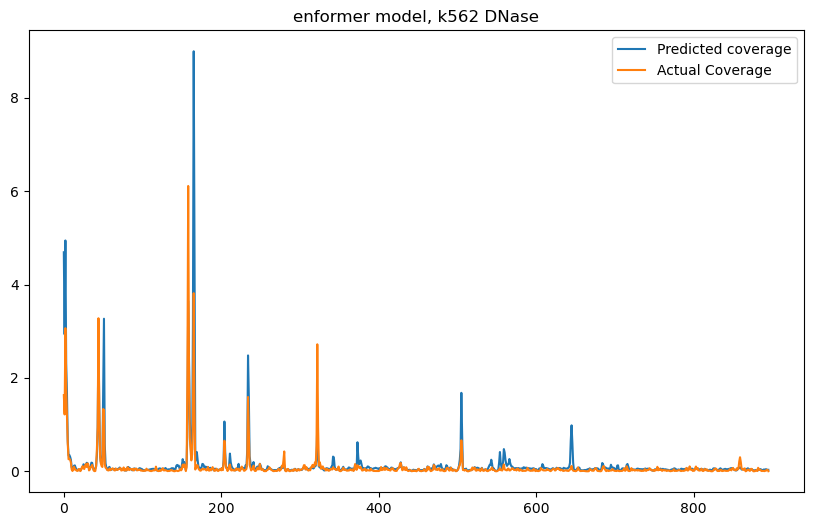

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(predictions['human'][0,:,121], label='Predicted coverage')
plt.plot(templabels[:,121], label='Actual Coverage')
plt.legend()
plt.title('enformer model, k562 DNase')

In [34]:
#correlate them together using numpy
np.corrcoef(predictions['human'][0,:,121], templabels[:,121])

array([[1.        , 0.82460011],
       [0.82460011, 1.        ]])